In [1]:
import os
import pandas as pd
from typing import Tuple
import shutil

def create_data_frame_form_folder(folder_path:str)->pd.DataFrame:
    """
    Create a dataframe with all image names
    Args:
        folder_path:

    Returns:

    """
    df = pd.DataFrame()
    full_file_name =[]
    date_l = []
    time_l =[]
    ms_l =[]
    imgnr_l=[]
    y_coord_l =[]
    x_coord_l =[]
    for root, dirs, files in os.walk(folder_path):
        for name in files:
            if name.endswith('.png'):
                full_file_name.append(name)
                name_split = name.split(" ")
                date_l.append(name_split[0])
                time_l.append(name_split[1])
                ms_l.append(name_split[3])
                imgnr_l.append(name_split[5])
                y_coord_l.append(name_split[6])
                x_coord_l.append(name_split[7].split(".")[0])
    df["date"] =date_l
    df["time"]=time_l
    df["ms"]=ms_l
    df["imgnr"]=imgnr_l
    df["y-coord"]=y_coord_l
    df["x-coord"]=x_coord_l
    df["filename"] = full_file_name
    df["path"] = folder_path
    df["ms"] =df["ms"].astype('int')
    df['x-coord'] =df['x-coord'].astype('int')
    df['y-coord'] =df['y-coord'].astype('int')
    df = df.sort_values(["date","time","ms"]).copy()
    df["date_time"] =df["date"].astype('str')+df["time"].astype('str')
    print(df.shape)
    return df

In [2]:
df = create_data_frame_form_folder("data/5_cruises/PS99.2")

(28491, 9)


In [3]:
df_sort =df.sort_values(by=["date","time","ms","imgnr"])

In [4]:
df_sort

,date,time,ms,imgnr,y-coord,x-coord,filename,path,date_time
5254,20160630,162847,519,000000,180,774,20160630 162847 519 000000 0180 0774.png,data/5_cruises/PS99.2,20160630162847
23704,20160630,162855,19,000000,1869,1551,20160630 162855 019 000000 1869 1551.png,data/5_cruises/PS99.2,20160630162855
3465,20160630,162855,469,000000,2052,1395,20160630 162855 469 000000 2052 1395.png,data/5_cruises/PS99.2,20160630162855
886,20160630,162926,118,000000,1920,885,20160630 162926 118 000000 1920 0885.png,data/5_cruises/PS99.2,20160630162926
14772,20160630,162926,168,000000,501,1122,20160630 162926 168 000000 0501 1122.png,data/5_cruises/PS99.2,20160630162926
...,...,...,...,...,...,...,...,...,...
17017,20160707,025359,672,000005,1188,762,20160707 025359 672 000005 1188 0762.png,data/5_cruises/PS99.2,20160707025359
18184,20160707,025359,672,000006,177,777,20160707 025359 672 000006 0177 0777.png,data/5_cruises/PS99.2,20160707025359
15759,20160707,025359,672,000008,426,969,20160707 025359 672 000008 0426 0969.png,data/5_cruises/PS99.2,20160707025359
19186,20160707,025359,672,000009,915,990,20160707 025359 672 000009 0915 0990.png,data/5_cruises/PS99.2,20160707025359


In [5]:
df_sort.max()

date                                           20160707
time                                             233659
ms                                                  999
imgnr                                            000049
y-coord                                            2205
x-coord                                            1620
filename     20160707 025359  672  000011 0000 1068.png
path                              data/5_cruises/PS99.2
date_time                                20160707025359
dtype: object

In [6]:
df_sort.columns

Index(['date', 'time', 'ms', 'imgnr', 'y-coord', 'x-coord', 'filename', 'path',
       'date_time'],
      dtype='object')

In [7]:
##
import pandas as pd
theta, alpha, beta = (60,2000,2000)
# Step 2: Read data into a DataFrame (assuming your DataFrame is named 'df')
# df = pd.read_csv('your_data.csv')

# Step 3: Create a function to check for duplicates
def are_duplicates(img1, img2, theta, alpha, beta):
    if (img2['ms'] - img1['ms'] < theta and
            img2['x-coord'] - img1['x-coord'] < alpha and
            img2['y-coord'] - img1['y-coord'] < beta):
        return True
    return False

# Step 4: Group the DataFrame by ['date', 'time', 'ms']
grouped = df_sort.groupby(['date', 'time', 'ms'])

# Step 5: Iterate over each group to find duplicates and update the 'filename' column
duplicates = {}
for _, group in grouped:
    filenames = list(group['filename'])
    updated_filenames = []
    for filename in filenames:
        img1 = group[group['filename'] == filename].iloc[0]  # Take the first image with the same filename
        duplicates[filename] = [filename]  # Add itself to the duplicates list
        for _, img2 in group.iterrows():
            if img1['filename'] != img2['filename'] and are_duplicates(img1, img2, theta, alpha, beta):
                duplicates[filename].append(img2['filename'])
                duplicates[filename].sort()
# Step 6: Create a new DataFrame with the updated 'filename' column and count of duplicates
df_duplicates = pd.DataFrame({'filename': list(duplicates.keys()), 'duplicates': list(duplicates.values())})

# Add a new column 'dub' containing the number of duplicates found
df_duplicates['dub'] = df_duplicates['duplicates'].apply(lambda x: len(x) - 1)

# Create a dictionary to map filenames to 'keep' values
keep_map = {}
for _, row in df_duplicates.iterrows():
    duplicates_list = row['duplicates']
    filename = row['filename']
    if len(duplicates_list) == 1:
        keep_map[filename] = 1
    else:
        if filename != duplicates_list[0]:
            keep_map[filename] = 0
        else:
            keep_map[filename] = 1

# Add the 'keep' column to the original DataFrame
merged_df4 = pd.merge(df_sort, df_duplicates, on='filename', how='left')
merged_df4['keep'] = merged_df4['filename'].map(keep_map).fillna(1)

# Print the merged DataFrame to see the result
print(merged_df4)

           date    time   ms   imgnr  y-coord  x-coord  \
0      20160630  162847  519  000000      180      774   
1      20160630  162855   19  000000     1869     1551   
2      20160630  162855  469  000000     2052     1395   
3      20160630  162926  118  000000     1920      885   
4      20160630  162926  168  000000      501     1122   
...         ...     ...  ...     ...      ...      ...   
28486  20160707  025359  672  000005     1188      762   
28487  20160707  025359  672  000006      177      777   
28488  20160707  025359  672  000008      426      969   
28489  20160707  025359  672  000009      915      990   
28490  20160707  025359  672  000011        0     1068   

                                         filename                   path  \
0      20160630 162847  519  000000 0180 0774.png  data/5_cruises/PS99.2   
1      20160630 162855  019  000000 1869 1551.png  data/5_cruises/PS99.2   
2      20160630 162855  469  000000 2052 1395.png  data/5_cruises/PS99.2   

In [8]:
merged_df4["keep"].sum()

21249

In [9]:
merged_df4.to_csv("barbara/zooomieeee.csv", sep=";")

In [10]:
df_all = pd.read_csv("output/update_allcruises_df_validated_5with_zoomie_20230727.csv",sep=";")
df_all = df_all[df_all['object_cruise']=="PS99.2"]
df_artefacts = df_all[df_all["label"] == "Artefact"]
df_artefacts.shape

(5592, 109)

In [11]:
nic = set(df_artefacts["img_file_name"].tolist())
len(nic)

5592

In [12]:
doubles = set(merged_df4[merged_df4["keep"]==0]["filename"].tolist())
def flatten_list(input_list):
    return sum(input_list, [])
doubles2 = set(flatten_list((merged_df4[merged_df4["dub"]!=0]["duplicates"].tolist())))
print(len(doubles))

7242


In [13]:
len(nic.difference(doubles))

3196

In [14]:
len(doubles.difference(nic))

4846

In [15]:
len(nic.intersection(doubles))/len(nic)*100

42.846924177396275

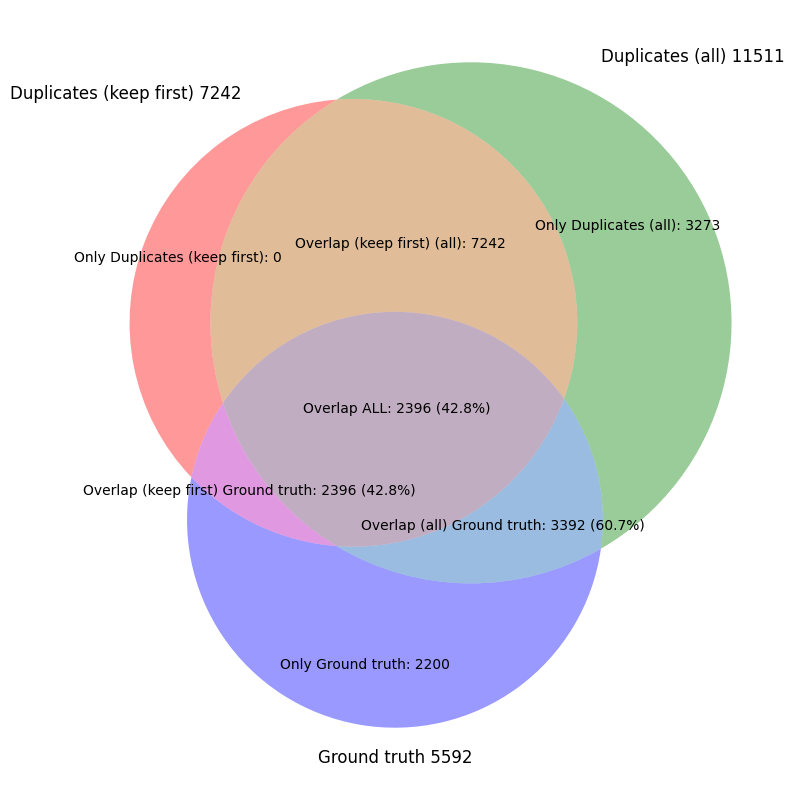

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Example lists
list1 = doubles
list2 = doubles2
list3 = nic

# Convert lists to sets for Venn diagram
set1 = set(list1)
set2 = set(list2)
set3 = set(list3)

# Calculate the sizes of the exclusive areas
list1_exclusive_size = len(set1.difference(set2.union(set3)))
list2_exclusive_size = len(set2.difference(set1.union(set3)))
list3_exclusive_size = len(set3.difference(set1.union(set2)))

# Calculate the sizes of the intersection areas
intersection12_size = len(set1.intersection(set2))
intersection13_size = len(set1.intersection(set3))
intersection23_size = len(set2.intersection(set3))
intersection123_size = len(set1.intersection(set2, set3))

# Calculate the total size for percentage calculation
total_size = len(set1.union(set2, set3))

# Create a new figure with a specific size
plt.figure(figsize=(12, 10))

# Create a Venn diagram
venn_diagram = venn3(subsets=(list1_exclusive_size, list2_exclusive_size, intersection12_size,
                              list3_exclusive_size, intersection13_size, intersection23_size,
                              intersection123_size),
                     set_labels=(f'Duplicates (keep first) {len(set1)}', f'Duplicates (all) {len(set2)}', f'Ground truth {len(set3)}'))

# Customize the Venn diagram (if desired)
venn_diagram.get_label_by_id('100').set_text(
    f'Only Duplicates (keep first): {list1_exclusive_size}')
venn_diagram.get_label_by_id('010').set_text(
    f'Only Duplicates (all): {list2_exclusive_size}')
venn_diagram.get_label_by_id('001').set_text(
    f'Only Ground truth: {list3_exclusive_size} ')
venn_diagram.get_label_by_id('110').set_text(
    f'Overlap (keep first) (all): {intersection12_size} ')
venn_diagram.get_label_by_id('101').set_text(
    f'Overlap (keep first) Ground truth: {intersection13_size} ({(intersection13_size / len(set(nic))) * 100:.1f}%)')
venn_diagram.get_label_by_id('011').set_text(
    f'Overlap (all) Ground truth: {intersection23_size} ({(intersection23_size / len(set(nic))) * 100:.1f}%)')
venn_diagram.get_label_by_id('111').set_text(
    f'Overlap ALL: {intersection123_size} ({(intersection123_size / len(set(nic))) * 100:.1f}%)')

# Save the plot as an image file (e.g., PNG format)
#plt.title("Venn Diagram of Duplicates (keep first), Duplicates (all), and Nicole - for the % with (Ground truth is Base)")
plt.savefig("barbara/Ground truth_venn_diagram_3_class_diff_60_2000_2000.png")

# Show the plot (optional)
plt.show()